In [ ]:
run_project = input("Czy chcesz uruchomić projekt? (tak/nie): ").lower()

if run_project != 'tak':
    raise SystemExit("Projekt nie zostanie uruchomiony.")
print("Projekt uruchomiony.")

# Biblioteki

In [ ]:
from pathlib import Path
import re
from collections import OrderedDict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import loguniform, uniform

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    RandomizedSearchCV,
    cross_validate
)
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    matthews_corrcoef,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
    classification_report
)

from IPython.display import display

import joblib
import kagglehub
import pathlib


# EDA

 Załadowano 768 wierszy i 9 kolumn.



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Statystyki opisowe:


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00



Rozkład klas:


,count
Outcome,
Brak cukrzycy,500
Cukrzyca,268


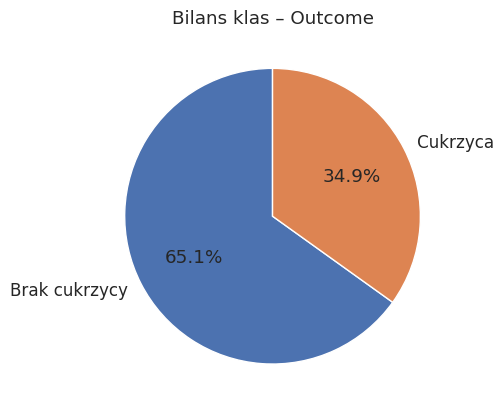


Wartości 0 (traktowane jako braki):


,Liczba zer
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11


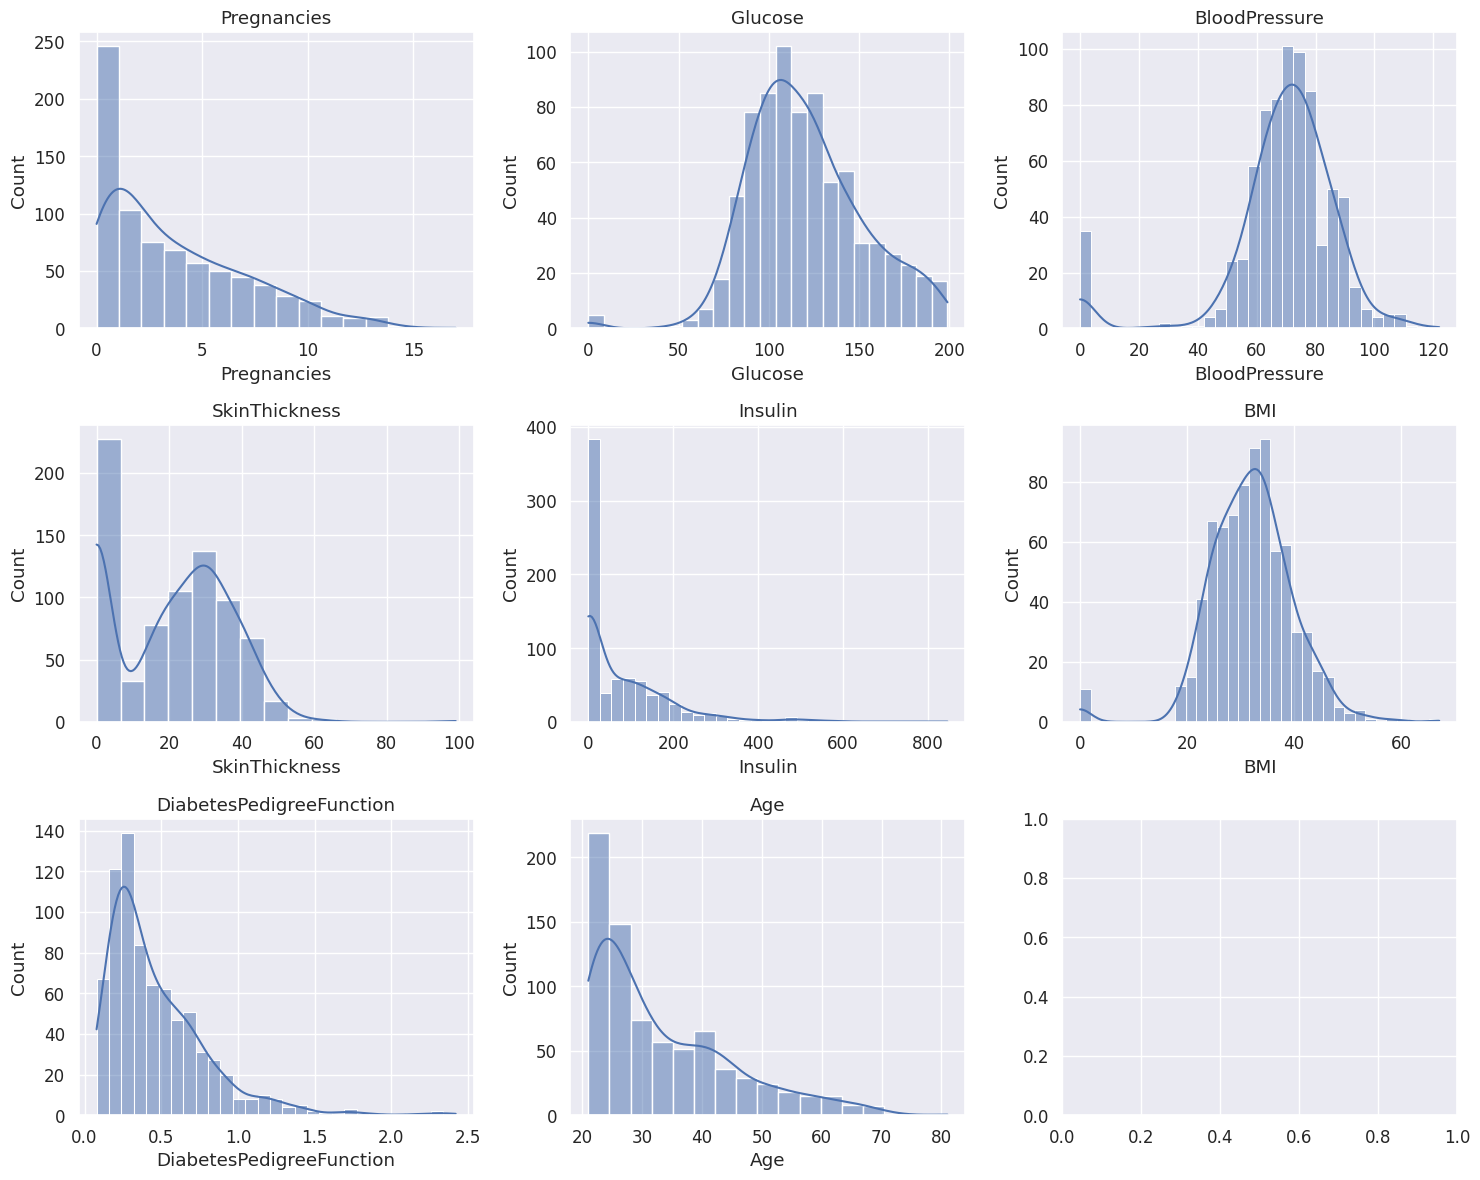

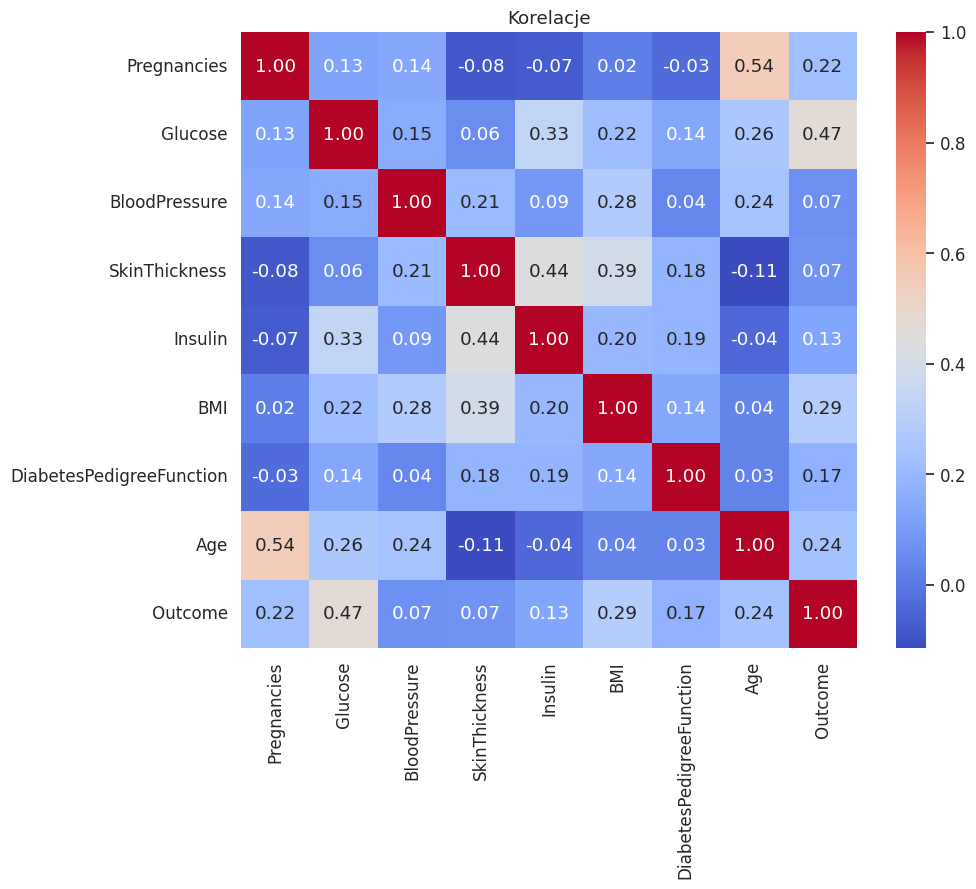

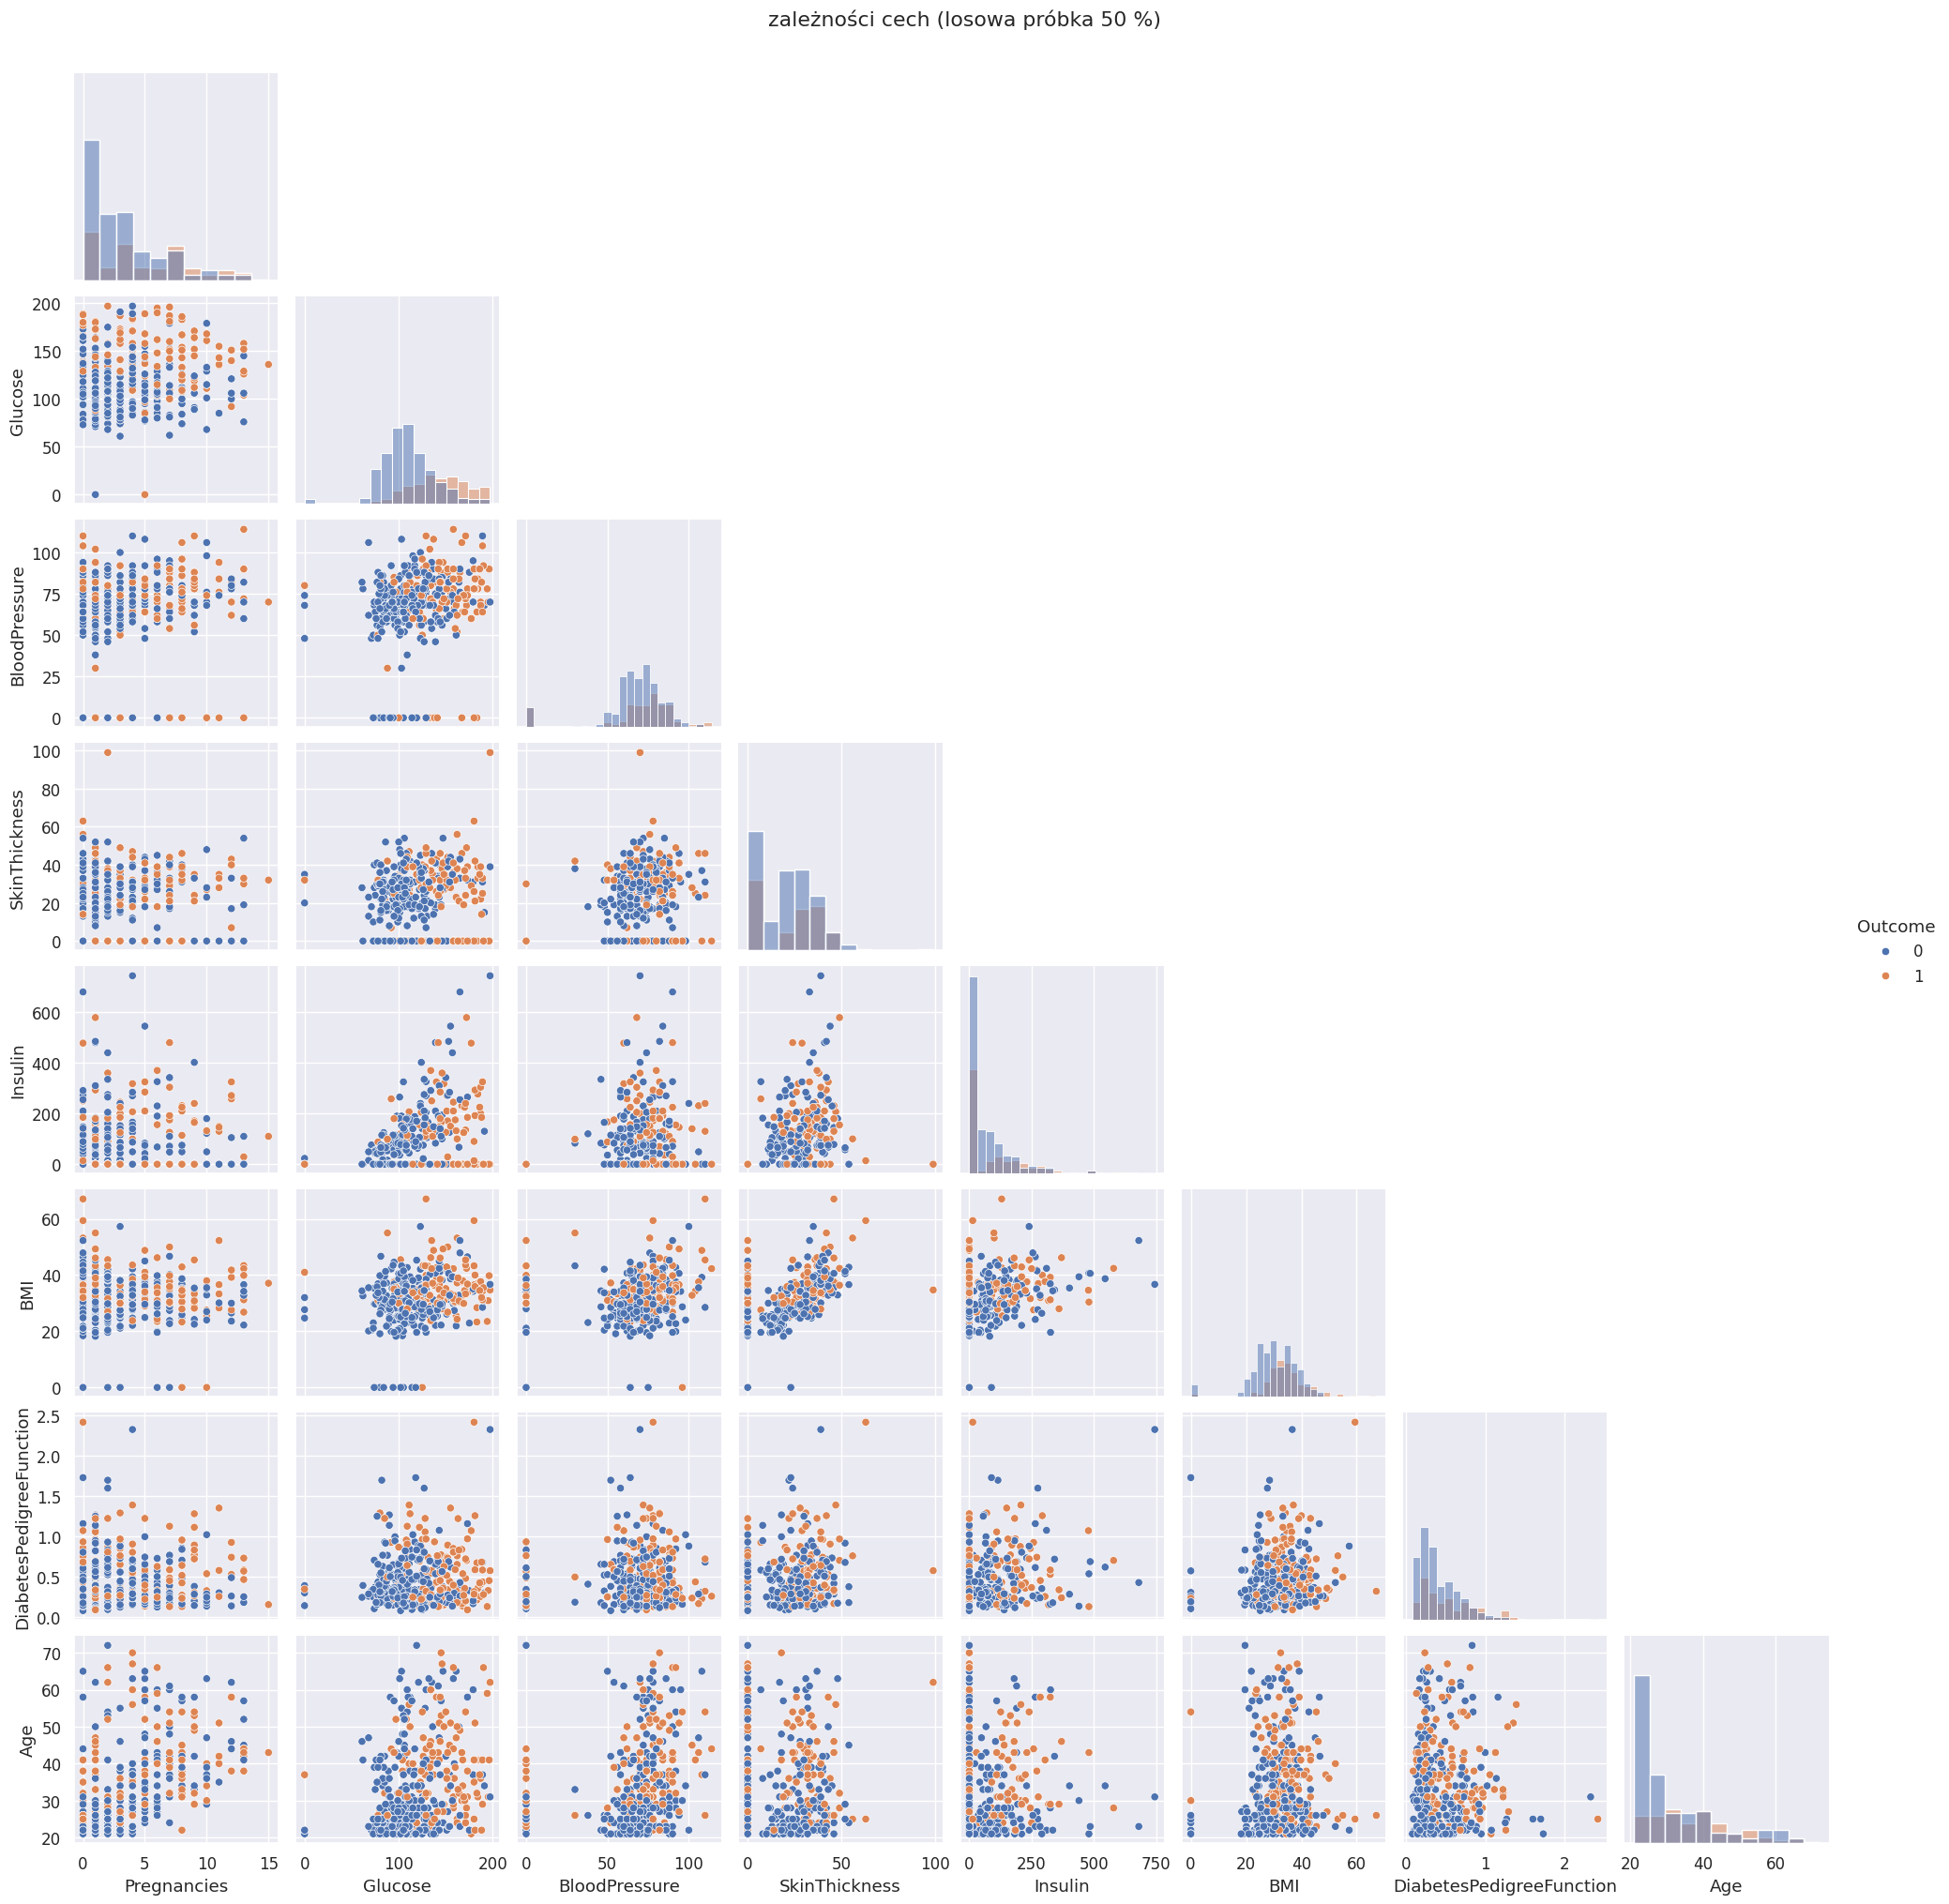

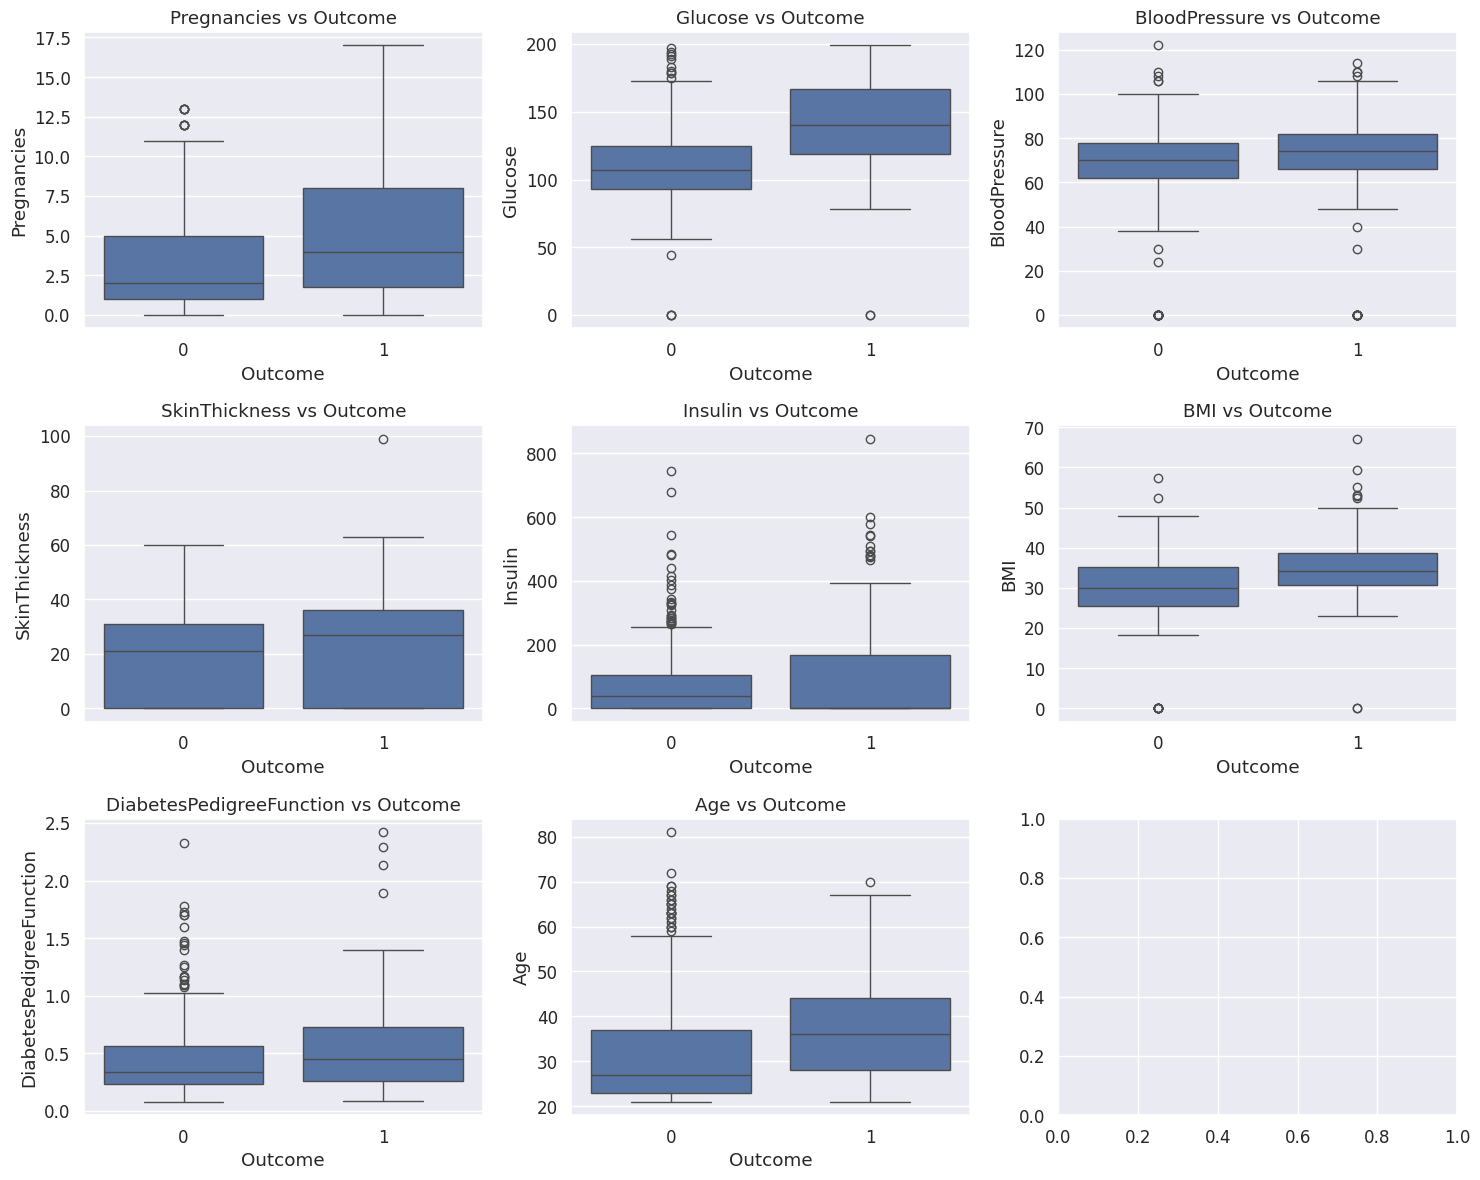

In [ ]:
plt.style.use("default")  # styl wykresów
sns.set(font_scale=1.1)    # skala czcionki
pd.set_option("display.max_columns", None)  # wyświetlanie wszystkich kolumn

path = kagglehub.dataset_download("uciml/pima-indians-diabetes-database")  # pobranie zbioru danych
path = pathlib.Path(path)  # konwersja na obiekt Path
csv_path = (path / "diabetes.csv").as_posix()  # ścieżka do pliku CSV

df = pd.read_csv(csv_path)  # wczytanie danych
print(f" Załadowano {df.shape[0]} wierszy i {df.shape[1]} kolumn.\n")  # podsumowanie rozmiaru
display(df.head())  # podgląd pierwszych wierszy
df.info()  # struktura DataFrame
print("\nStatystyki opisowe:")  # nagłówek statystyk
display(df.describe().T)  # statystyki opisowe

class_counts = df["Outcome"].value_counts().rename(index={0:"Brak cukrzycy",1:"Cukrzyca"})  # rozkład klas
print("\nRozkład klas:")  # nagłówek rozkładu
display(class_counts)  # wyświetlenie rozkładu

fig, ax = plt.subplots()  # inicjalizacja wykresu
ax.pie(class_counts, labels=class_counts.index, autopct="%1.1f%%", startangle=90)  # wykres kołowy klas
ax.set_title("Bilans klas – Outcome")  # tytuł wykresu
plt.show()  # wyświetlenie wykresu

zero_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]  # kolumny z wartościami zero
zero_summary = (df[zero_cols] == 0).sum().to_frame("Liczba zer")  # zliczenie zer
print("\nWartości 0 (traktowane jako braki):")  # nagłówek braków
display(zero_summary)  # wyświetlenie braków

num_cols = df.columns.drop("Outcome")  # cechy numeryczne
fig, axes = plt.subplots(len(num_cols)//3 + 1, 3, figsize=(15, 12))  # siatka histogramów
axes = axes.flat  # spłaszczenie listy osi
for i, col in enumerate(num_cols):  # iteracja po cechach
    sns.histplot(df[col], kde=True, ax=axes[i])  # histogram z KDE
    axes[i].set_title(col)  # tytuł wykresu
plt.tight_layout()  # układ wykresów
plt.show()  # wyświetlenie histogramów

corr = df.corr(numeric_only=True)  # macierz korelacji
plt.figure(figsize=(10, 8))  # rozmiar mapy cieplnej
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)  # mapa cieplna korelacji
plt.title("Korelacje")  # tytuł mapy
plt.show()  # wyświetlenie mapy

sns.pairplot(df.sample(frac=0.5, random_state=42), hue="Outcome",  # analiza par cech
             vars=num_cols, diag_kind="hist", corner=True)
plt.suptitle("zależności cech (losowa próbka 50 %)", y=1.02)  # tytuł zbiorczy
plt.show()  # wyświetlenie pairplot

fig, axes = plt.subplots(len(num_cols)//3 + 1, 3, figsize=(15, 12))  # siatka wykresów pudełkowych
axes = axes.flat  # spłaszczenie listy osi
for i, col in enumerate(num_cols):  # iteracja po cechach
    sns.boxplot(x="Outcome", y=col, data=df, ax=axes[i])  # wykres pudełkowy
    axes[i].set_title(f"{col} vs Outcome")  # tytuł wykresu
plt.tight_layout()  # układ wykresów
plt.show()  # wyświetlenie wykresów pudełkowych


# Preprocessing

In [ ]:
target = "Outcome"  # zmienna celu
feature_cols = df.columns.drop(target).tolist()  # lista cech
zero_mask_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]  # kolumny: 0 → NaN

X = df[feature_cols].copy()  # dane wejściowe
y = df[target].copy()  # etykiety

class ZeroToNaN(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols  # kolumny do konwersji
    def fit(self, X, y=None):
        return self  # brak dopasowania
    def transform(self, X):
        X = X.copy()  # kopia danych
        X[self.cols] = X[self.cols].replace(0, np.nan)  # zastąpienie 0 przez NaN
        return X  # zwrócenie przetworzonych danych

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_q=0.01, upper_q=0.99):
        self.lower_q = lower_q  # dolny kwantyl
        self.upper_q = upper_q  # górny kwantyl
    def fit(self, X, y=None):
        q_low  = np.nanquantile(X, self.lower_q, axis=0)  # obliczenie dolnego kwantyla
        q_high = np.nanquantile(X, self.upper_q, axis=0)  # obliczenie górnego kwantyla
        self.bounds_ = np.vstack([q_low, q_high]).T  # macierz progów (n_cech × 2)
        return self  # zwrócenie instancji
    def transform(self, X):
        X = X.copy()  # kopia danych
        for i in range(X.shape[1]):  # iteracja po kolumnach
            lo, hi = self.bounds_[i]  # zakres przycinania
            X[:, i] = np.clip(X[:, i], lo, hi)  # winsoryzacja
        return X  # zwrócenie przyciętych danych

numeric_pipeline = Pipeline(steps=[
    ("zero_to_nan", ZeroToNaN(zero_mask_cols)),  # usuwanie zer → brak
    ("imputer",     SimpleImputer(strategy="median")),  # imputacja medianą
    ("winsor",      Winsorizer(0.01, 0.99)),  # winsoryzacja
    ("scaler",      StandardScaler())  # skalowanie (standaryzacja)
])

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_pipeline, feature_cols)],  # przetwarzanie numeryczne
    remainder="drop"  # odrzucenie pozostałych kolumn
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42  # podział danych
)

X_train_processed = preprocessor.fit_transform(X_train)  # fit + transform (train)
X_test_processed  = preprocessor.transform(X_test)  # transform (test)

print(f"Po przetwarzaniu: X_train={X_train_processed.shape},  X_test={X_test_processed.shape}")  # podsumowanie


Po przetwarzaniu: X_train=(614, 8),  X_test=(154, 8)


# EDA po preprocessingu

Załadowano 614 wierszy i 8 kolumn.



,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,-0.855842,-1.064104,-0.860858,-2.036813,-1.268315,-0.787625,0.336349,-0.798945
1,0.361973,0.143354,0.490937,-0.233405,-1.534800,-0.423641,-0.111619,0.573469
2,-0.551388,-0.560996,-1.198807,1.329548,-0.579827,0.380155,-0.791515,-0.713169
3,-0.855842,0.814164,-1.367782,0.007049,-0.161334,-0.408475,0.285516,-0.370065
4,-1.160296,-0.896401,-0.691884,1.209321,-0.431329,1.851255,-0.343546,-0.970496


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               614 non-null    float64
 1   Glucose                   614 non-null    float64
 2   BloodPressure             614 non-null    float64
 3   SkinThickness             614 non-null    float64
 4   Insulin                   614 non-null    float64
 5   BMI                       614 non-null    float64
 6   DiabetesPedigreeFunction  614 non-null    float64
 7   Age                       614 non-null    float64
dtypes: float64(8)
memory usage: 38.5 KB

Statystyki opisowe:


,count,mean,std,min,25%,50%,75%,max
Pregnancies,614.0,5.207561e-17,1.000815,-1.160296,-0.855842,-0.246935,0.666426,2.797602
Glucose,614.0,-1.157236e-17,1.000815,-1.788914,-0.762239,-0.158510,0.612921,2.491188
BloodPressure,614.0,4.166049e-16,1.000815,-2.381628,-0.691884,-0.015987,0.659911,3.003586
SkinThickness,614.0,1.272959e-16,1.000815,-2.277268,-0.473860,0.007049,0.367731,2.531820
Insulin,614.0,2.003464e-16,1.000815,-1.534800,-0.228833,-0.161334,-0.093835,4.833581
BMI,614.0,1.562268e-15,1.000815,-1.955405,-0.723169,0.001006,0.622811,2.664303
DiabetesPedigreeFunction,614.0,2.401264e-16,1.000815,-1.212415,-0.727973,-0.291125,0.524591,3.847852
Age,614.0,-1.128305e-16,1.000815,-1.056272,-0.798945,-0.370065,0.659245,2.803640



Rozkład klas:


,count
Outcome,
Brak cukrzycy,400
Cukrzyca,214


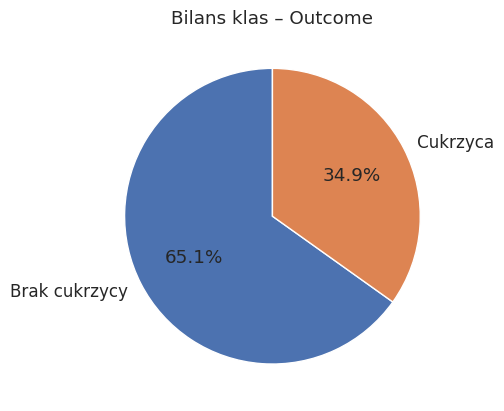


Wartości 0 (po preprocessingu):


,Liczba zer
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0


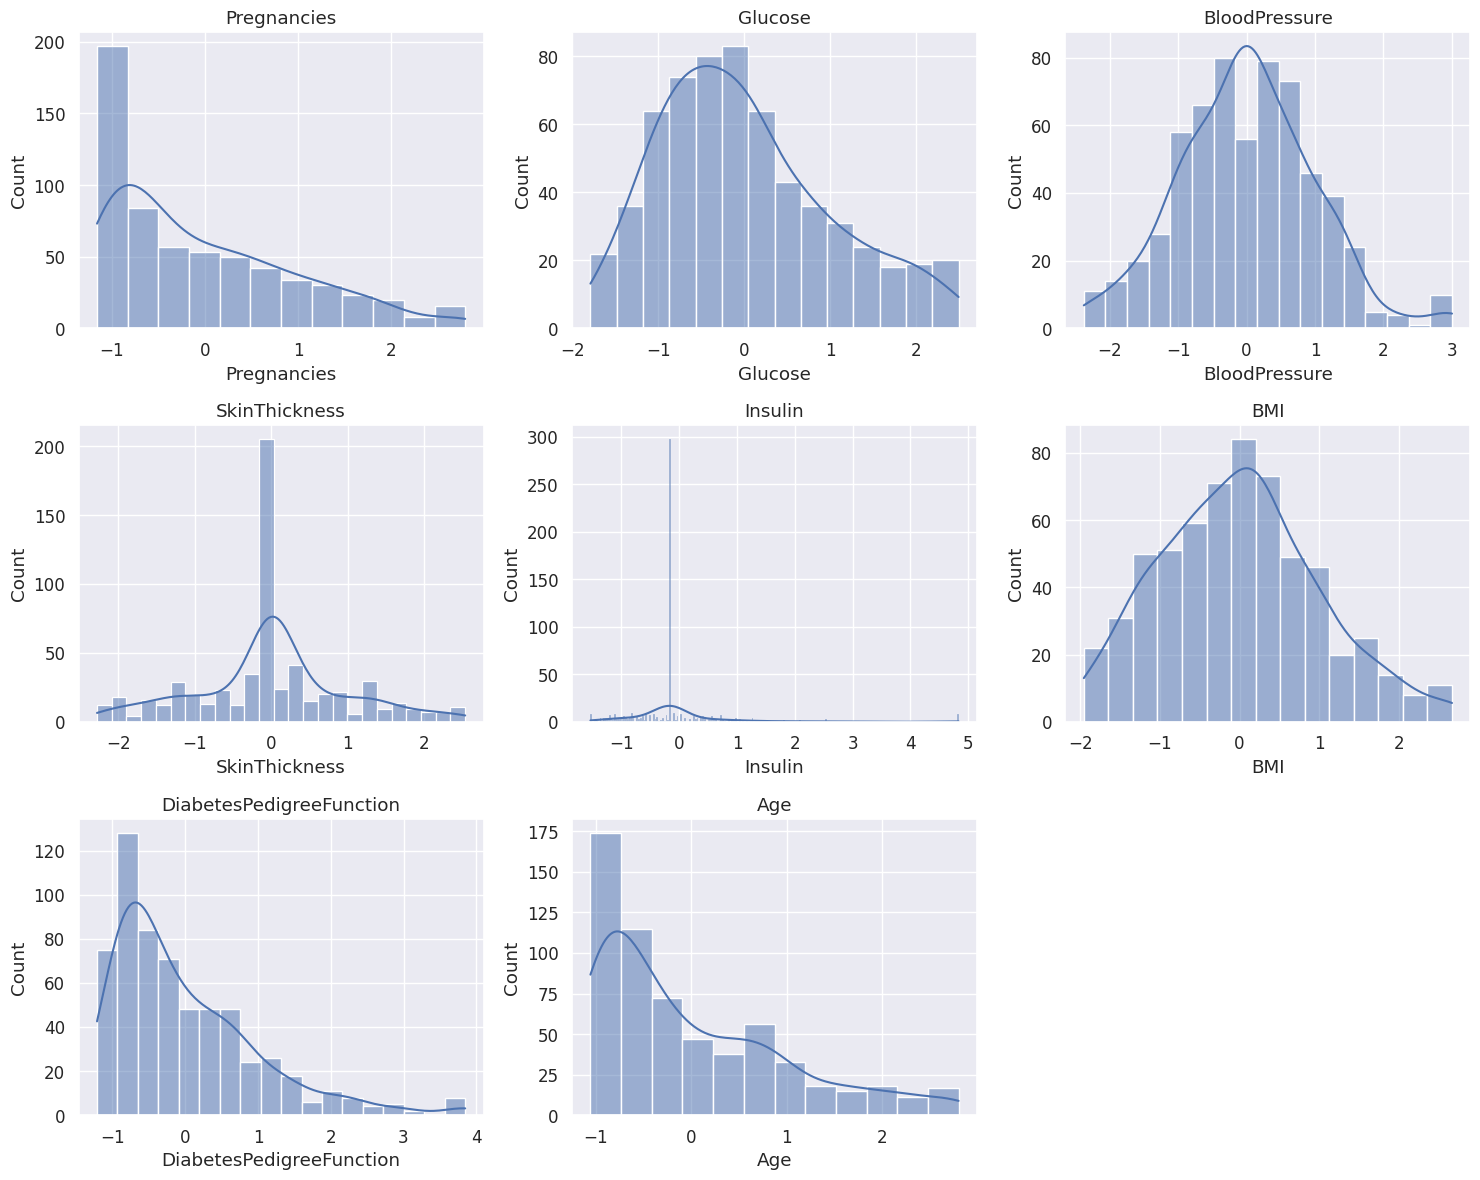

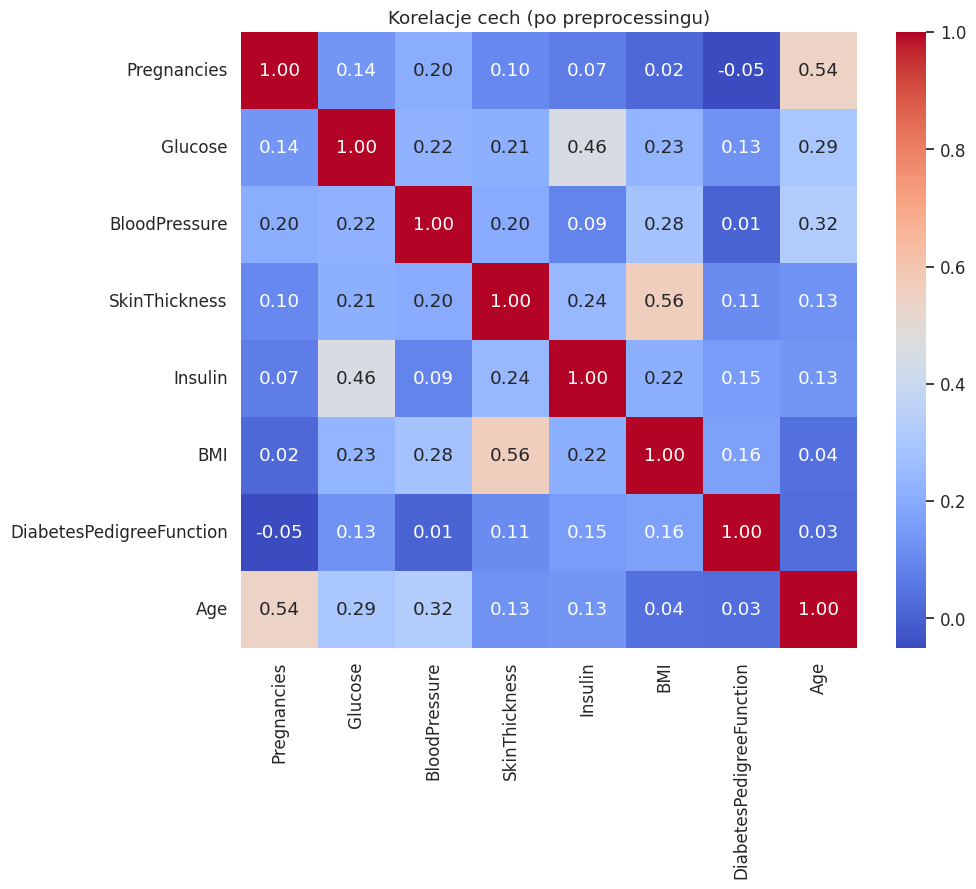

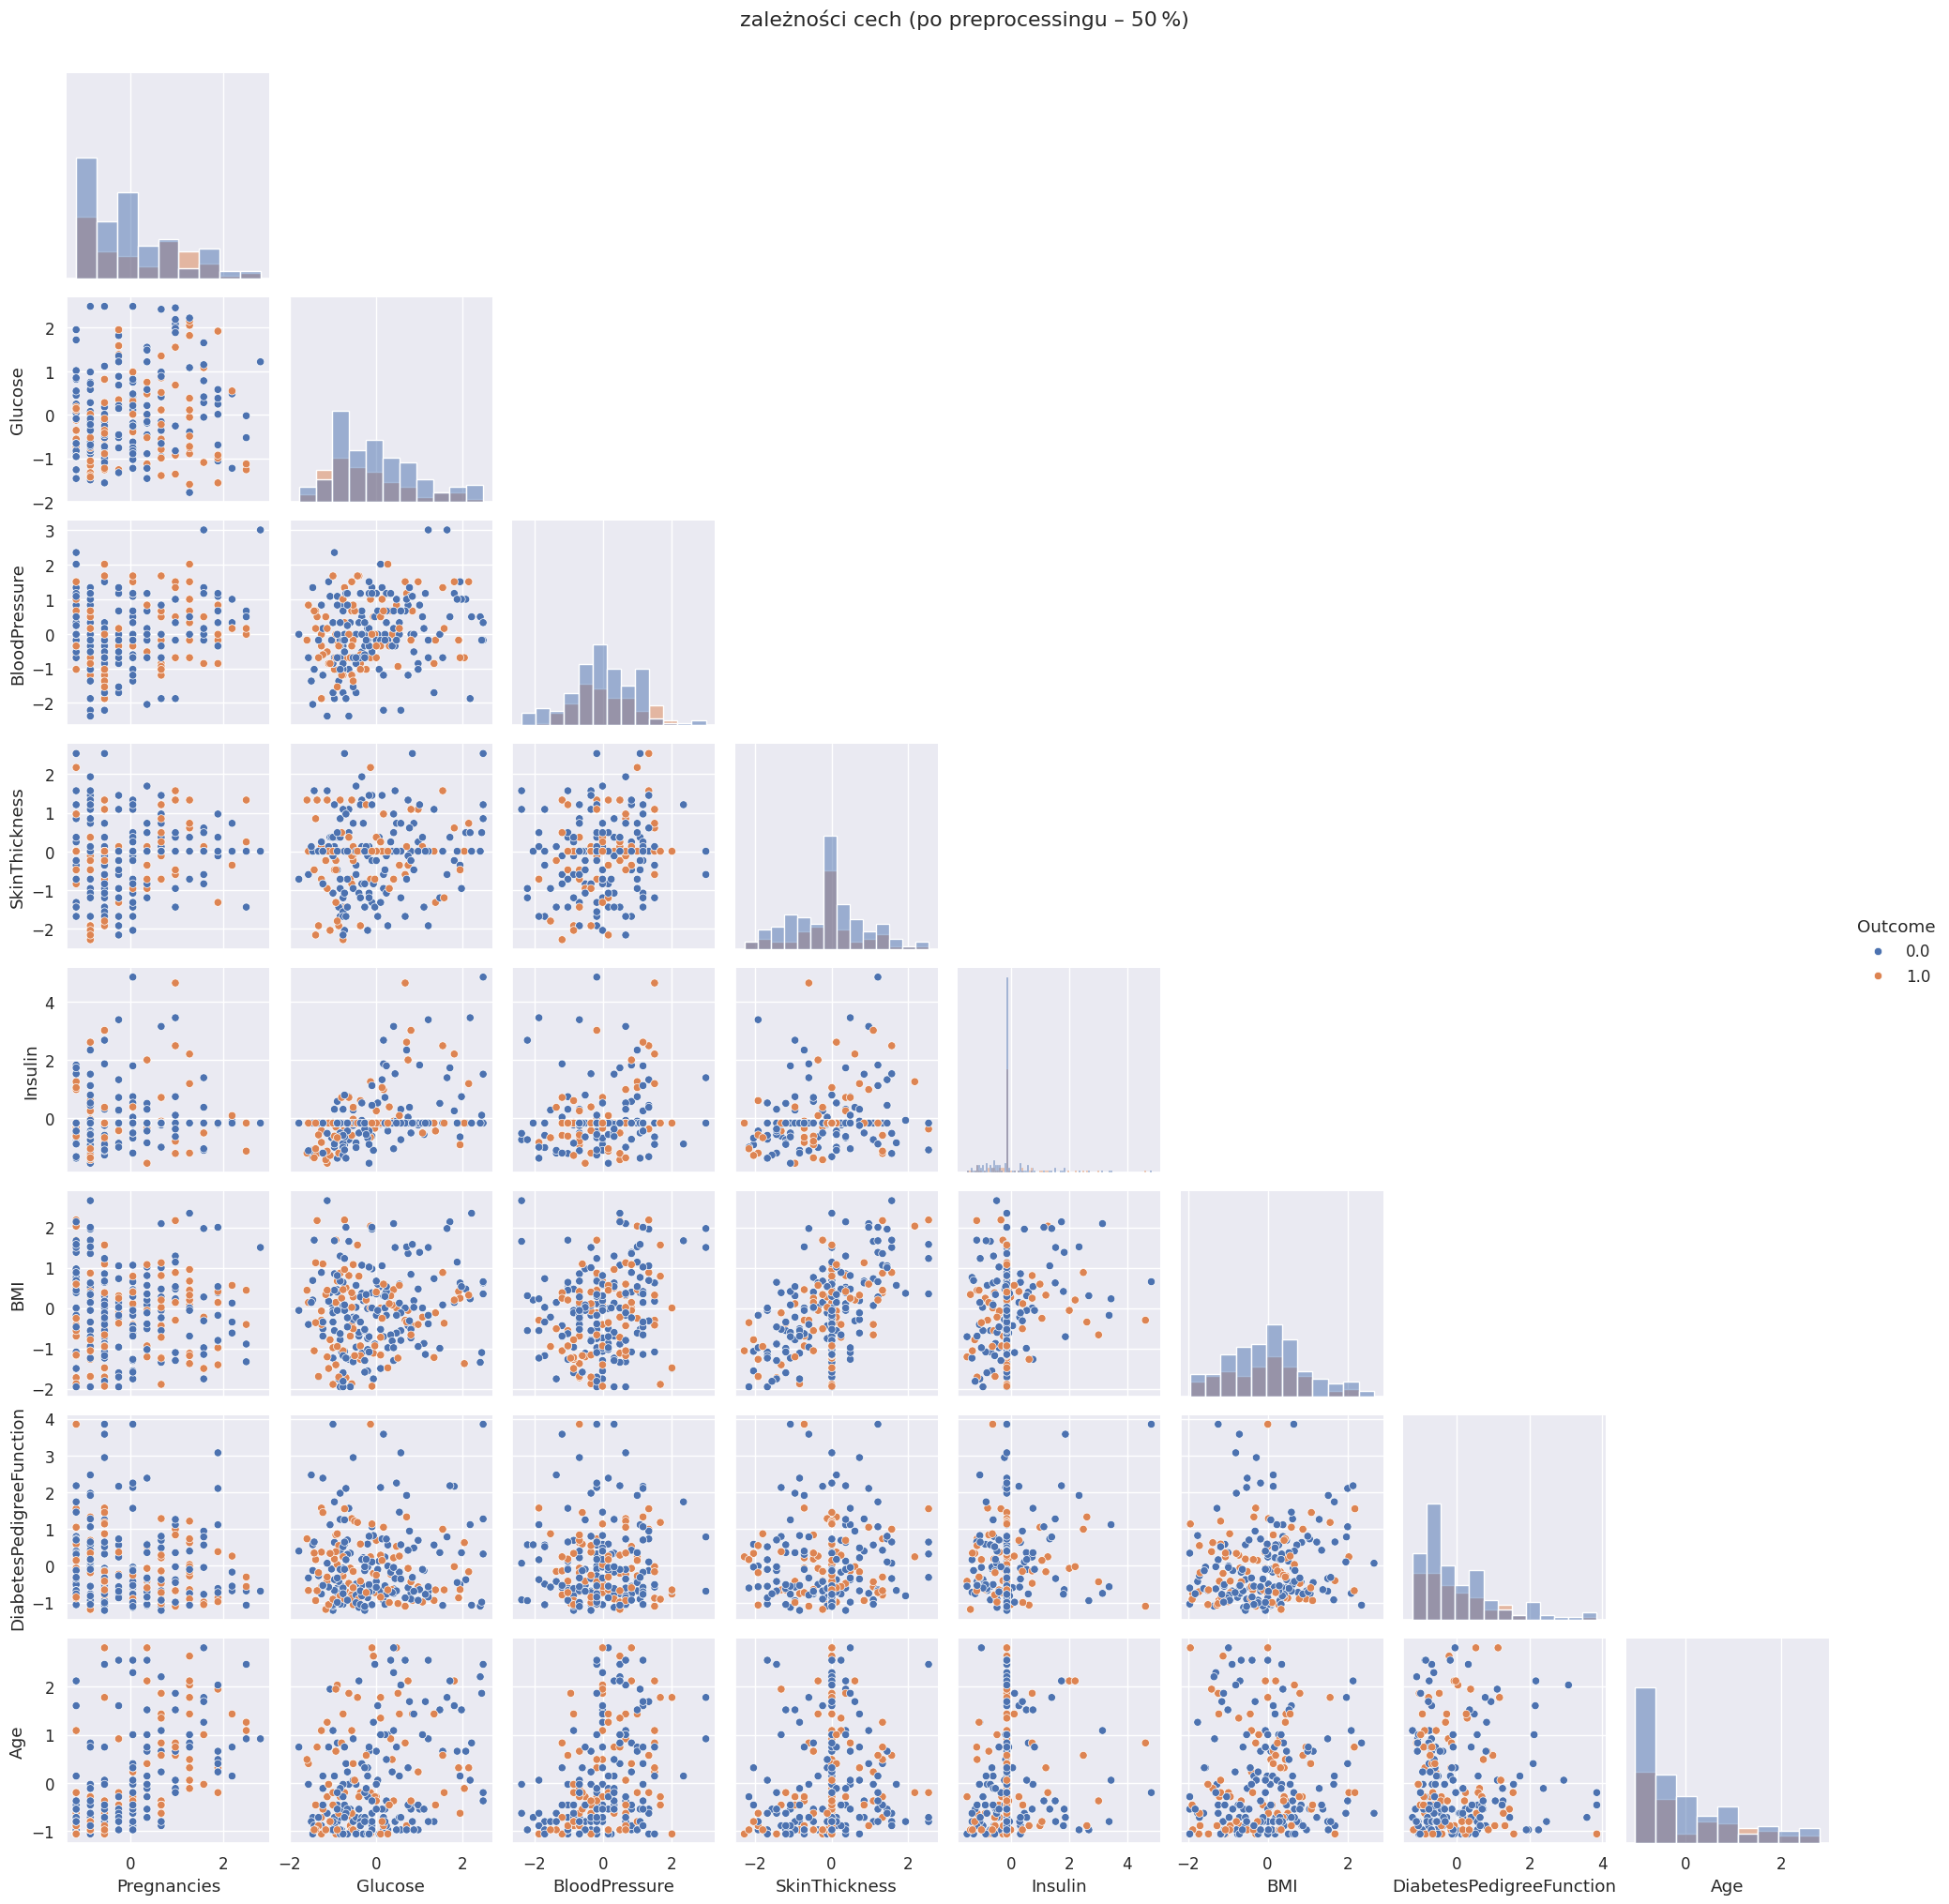

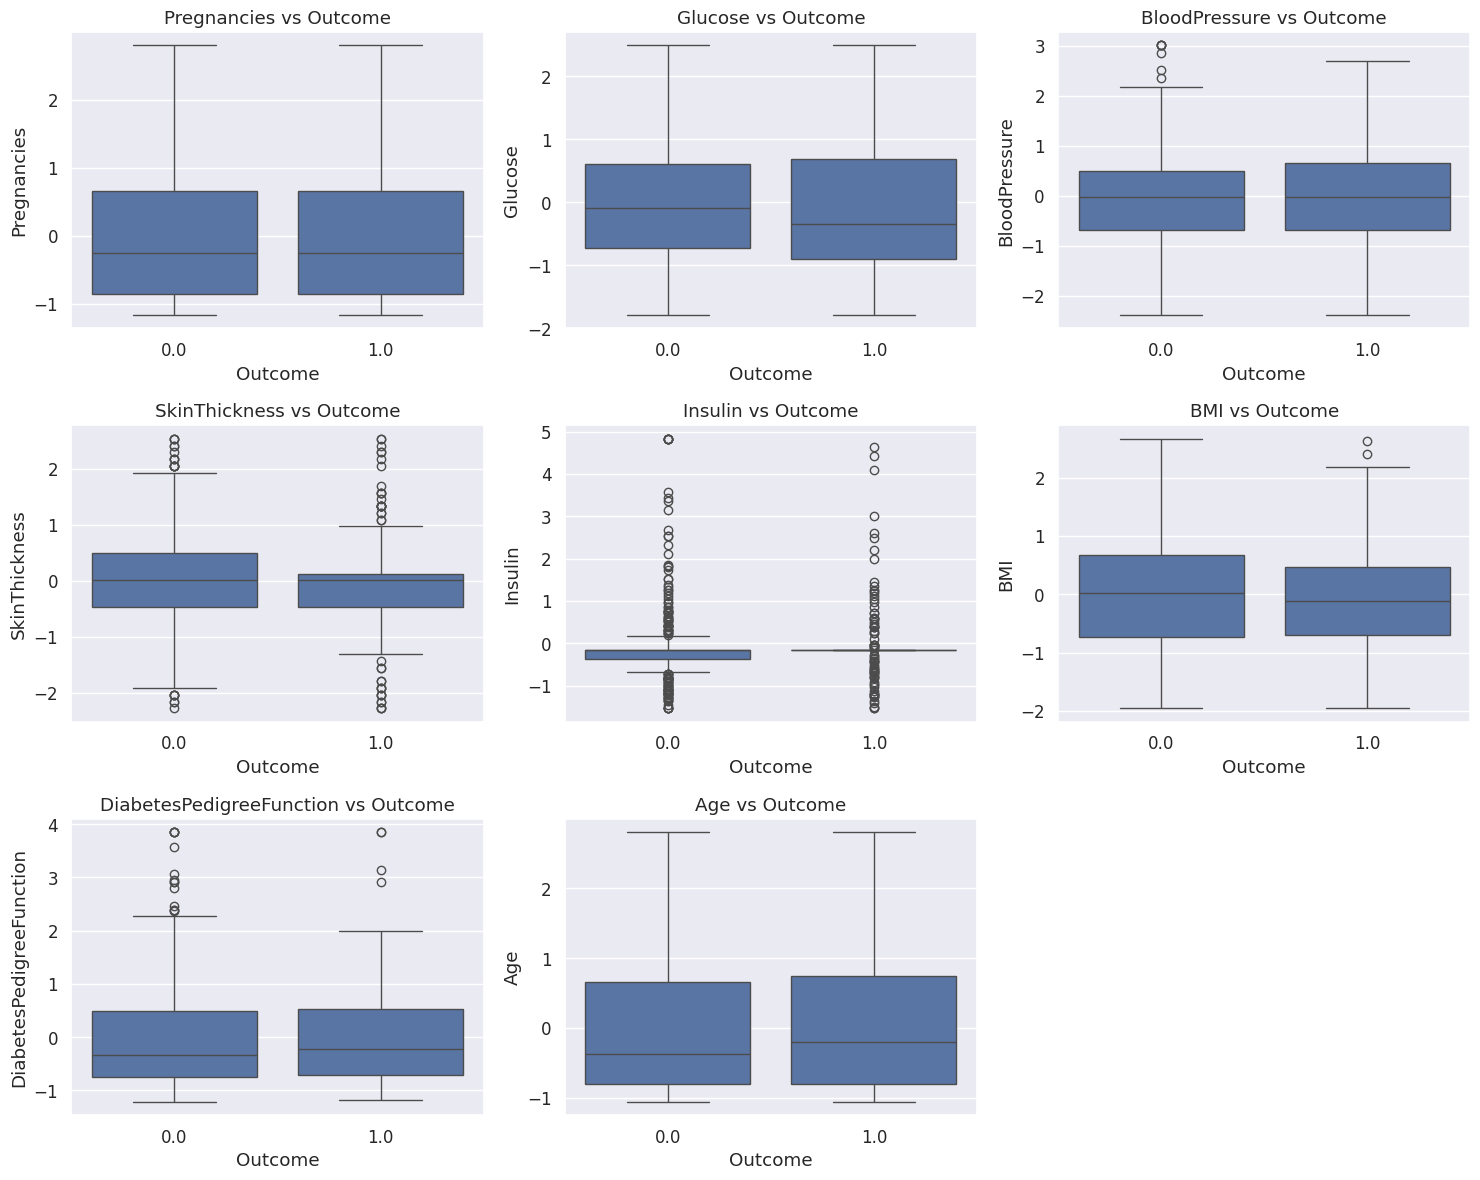

In [ ]:
proc_cols = feature_cols  # nazwy cech
X_train_df = pd.DataFrame(X_train_processed, columns=proc_cols)  # DataFrame train
X_test_df  = pd.DataFrame(X_test_processed,  columns=proc_cols)  # DataFrame test

print(f"Załadowano {X_train_df.shape[0]} wierszy i {X_train_df.shape[1]} kolumn.\n")  # podsumowanie rozmiarów
display(X_train_df.head())  # podgląd pierwszych wierszy
X_train_df.info()  # struktura DataFrame

print("\nStatystyki opisowe:")  # nagłówek statystyk
display(X_train_df.describe().T)  # statystyki opisowe

class_counts = y_train.value_counts().rename(index={0: "Brak cukrzycy", 1: "Cukrzyca"})  # rozkład klas
print("\nRozkład klas:")  # nagłówek rozkładu
display(class_counts)  # wyświetlenie rozkładu

fig, ax = plt.subplots()  # inicjalizacja wykresu
ax.pie(class_counts, labels=class_counts.index, autopct="%1.1f%%", startangle=90)  # wykres kołowy klas
ax.set_title("Bilans klas – Outcome")  # tytuł wykresu
plt.show()  # wyświetlenie wykresu

zero_summary = (X_train_df[zero_mask_cols] == 0).sum().to_frame("Liczba zer")  # podsumowanie zer
print("\nWartości 0 (po preprocessingu):")  # nagłówek zer
display(zero_summary)  # wyświetlenie liczby zer

num_cols = proc_cols  # cechy numeryczne
fig, axes = plt.subplots(len(num_cols)//3 + 1, 3, figsize=(15, 12))  # siatka histogramów
axes = axes.flat  # spłaszczenie listy osi
for i, col in enumerate(num_cols):  # iteracja po cechach
    sns.histplot(X_train_df[col], kde=True, ax=axes[i])  # histogram z KDE
    axes[i].set_title(col)  # tytuł wykresu
for ax in axes[len(num_cols):]:  # wyłączenie pustych osi
    ax.axis("off")
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie histogramów

corr = X_train_df.corr()  # macierz korelacji
plt.figure(figsize=(10, 8))  # rozmiar mapy cieplnej
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True)  # mapa cieplna korelacji
plt.title("Korelacje cech (po preprocessingu)")  # tytuł mapy
plt.show()  # wyświetlenie mapy

sns.pairplot(  # analiza par cech
    pd.concat([X_train_df, y_train], axis=1).sample(frac=0.5, random_state=42),
    hue="Outcome", vars=num_cols, diag_kind="hist", corner=True
)
plt.suptitle("zależności cech (po preprocessingu – 50 %)", y=1.02)  # zbiorczy tytuł
plt.show()  # wyświetlenie pairplot

fig, axes = plt.subplots(len(num_cols)//3 + 1, 3, figsize=(15, 12))  # siatka wykresów pudełkowych
axes = axes.flat  # spłaszczenie listy osi
for i, col in enumerate(num_cols):  # iteracja po cechach
    sns.boxplot(x=y_train, y=X_train_df[col], ax=axes[i])  # wykres pudełkowy
    axes[i].set_title(f"{col} vs Outcome")  # tytuł wykresu
for ax in axes[len(num_cols):]:  # wyłączenie pustych osi
    ax.axis("off")
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresów pudełkowych


# Hipeparametry + trening

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # walidacja krzyżowa stratifikowana

# 1) Model prosty – tylko parametr C
lr_simple = LogisticRegression(solver='liblinear', random_state=42)  # regresja logistyczna liniowa
param_simple = {'C': loguniform(1e-3, 1e3)}  # zakres regularyzacji
search_simple = RandomizedSearchCV(
    lr_simple,
    param_simple,
    n_iter=20,  # liczba prób
    scoring='roc_auc',  # metryka AUC
    cv=cv,  # przekazanie walidacji
    random_state=42,
    n_jobs=-1
)
search_simple.fit(X_train_processed, y_train)  # dopasowanie modelu
joblib.dump(search_simple.best_estimator_, 'logreg_simple.joblib')  # zapis najlepszego modelu

# 2) Model umiarkowany – C + penalty (L1, L2)
lr_mid = LogisticRegression(solver='saga', max_iter=10000, random_state=42)  # regresja logistyczna z solverem saga
param_mid = {
    'penalty': ['l1', 'l2'],  # typ kary
    'C': loguniform(1e-3, 1e3),  # zakres regularyzacji
    'class_weight': [None, 'balanced']  # wagi klas
}
search_mid = RandomizedSearchCV(
    lr_mid,
    param_mid,
    n_iter=40,  # liczba prób
    scoring='roc_auc',  # metryka AUC
    cv=cv,  # przekazanie walidacji
    random_state=42,
    n_jobs=-1
)
search_mid.fit(X_train_processed, y_train)  # dopasowanie modelu
joblib.dump(search_mid.best_estimator_, 'logreg_mid.joblib')  # zapis najlepszego modelu

# 3) Model zaawansowany – elasticnet (C + l1_ratio)
lr_adv = LogisticRegression(solver='saga', penalty='elasticnet', max_iter=10000, random_state=42)  # regresja logistyczna z karą elasticnet
param_adv = {
    'C': loguniform(1e-3, 1e3),  # zakres regularyzacji
    'l1_ratio': uniform(0, 1),  # proporcja L1
    'class_weight': [None, 'balanced']  # wagi klas
}
search_adv = RandomizedSearchCV(
    lr_adv,
    param_adv,
    n_iter=40,  # liczba prób
    scoring='roc_auc',  # metryka AUC
    cv=cv,  # przekazanie walidacji
    random_state=42,
    n_jobs=-1
)
search_adv.fit(X_train_processed, y_train)  # dopasowanie modelu
joblib.dump(search_adv.best_estimator_, 'logreg_advanced.joblib')  # zapis najlepszego modelu


['logreg_advanced.joblib']

#Ewaluacja

,CV_ROC_AUC,CV_Accuracy,CV_BalAcc,CV_Precision,CV_Recall,CV_F1,Test_Accuracy,Test_BalAcc,Test_Precision,Test_Recall,Test_F1,Test_ROC_AUC,Test_PR_AUC,Test_MCC
Model,,,,,,,,,,,,,,
Simple,0.845,0.780,0.736,0.732,0.589,0.652,0.708,0.669,0.592,0.537,0.563,0.808,0.662,0.345
Mid,0.846,0.762,0.750,0.646,0.710,0.675,0.714,0.703,0.581,0.667,0.621,0.809,0.669,0.396
Advanced,0.846,0.764,0.751,0.650,0.710,0.677,0.727,0.718,0.597,0.685,0.638,0.810,0.671,0.423


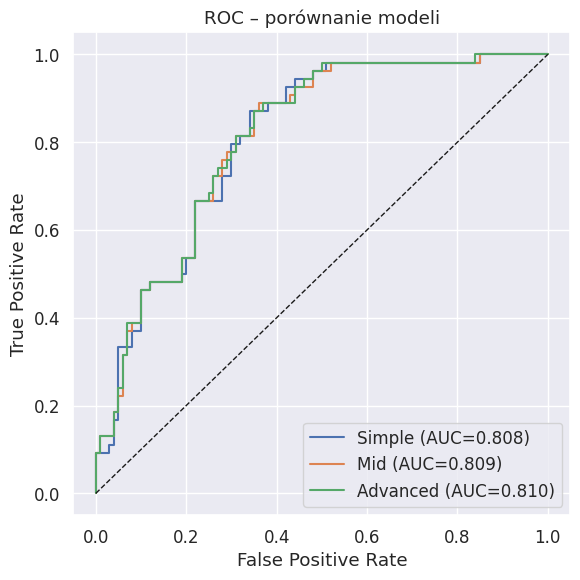

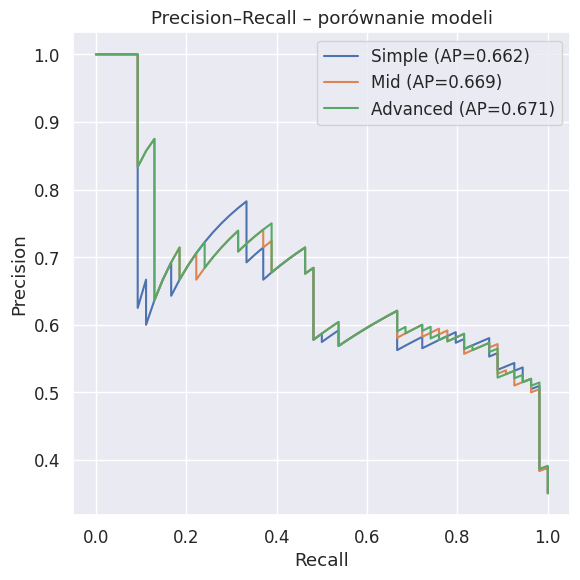

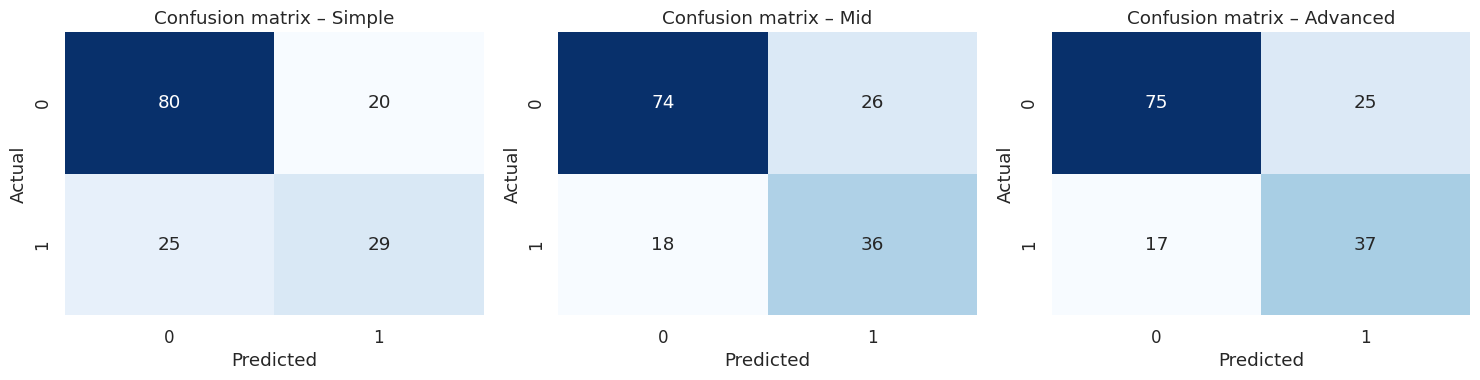

In [ ]:
models = {
    "Simple":   joblib.load("logreg_simple.joblib"),   # wczytanie modelu prostego
    "Mid":      joblib.load("logreg_mid.joblib"),      # wczytanie modelu umiarkowanego
    "Advanced": joblib.load("logreg_advanced.joblib"), # wczytanie modelu zaawansowanego
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # walidacja krzyżowa

records = []  # zbiór wyników
curves  = {}  # słownik krzywych

for tag, model in models.items():  # iteracja po modelach
    cv_res = cross_validate(
        model,
        X_train_processed,
        y_train,
        cv=cv,
        scoring={  # metryki CV
            "ROC_AUC": "roc_auc",
            "Accuracy": "accuracy",
            "BalAcc": "balanced_accuracy",
            "Precision": "precision",
            "Recall": "recall",
            "F1": "f1",
        },
        n_jobs=-1,
        return_train_score=False
    )

    y_proba = model.predict_proba(X_test_processed)[:, 1]  # prawdopodobieństwa
    y_pred  = model.predict(X_test_processed)               # predykcja klas
    rec = {
        "Model":          tag,  # oznaczenie modelu
        # metryki CV
        "CV_ROC_AUC":     cv_res["test_ROC_AUC"].mean(),    # średnia AUC CV
        "CV_Accuracy":    cv_res["test_Accuracy"].mean(),   # średnia Accuracy CV
        "CV_BalAcc":      cv_res["test_BalAcc"].mean(),     # średnia BalAcc CV
        "CV_Precision":   cv_res["test_Precision"].mean(),  # średnia Precision CV
        "CV_Recall":      cv_res["test_Recall"].mean(),     # średnia Recall CV
        "CV_F1":          cv_res["test_F1"].mean(),         # średnia F1 CV
        # metryki testowe
        "Test_Accuracy":  accuracy_score(y_test, y_pred),          # dokładność testu
        "Test_BalAcc":    balanced_accuracy_score(y_test, y_pred), # zbalansowana dokładność testu
        "Test_Precision": precision_score(y_test, y_pred, zero_division=0),  # precyzja testu
        "Test_Recall":    recall_score(y_test, y_pred, zero_division=0),     # czułość testu
        "Test_F1":        f1_score(y_test, y_pred, zero_division=0),         # F1 testu
        "Test_ROC_AUC":   roc_auc_score(y_test, y_proba),    # AUC ROC testu
        "Test_PR_AUC":    average_precision_score(y_test, y_proba),  # AUC PR testu
        "Test_MCC":       matthews_corrcoef(y_test, y_pred), # współczynnik MCC
    }
    records.append(rec)  # dodanie rekordu

    fpr, tpr, _    = roc_curve(y_test, y_proba)            # obliczenie ROC
    prec, rec_, _  = precision_recall_curve(y_test, y_proba)  # obliczenie PR
    curves[tag]    = {"fpr": fpr, "tpr": tpr, "prec": prec, "rec": rec_}  # zapis krzywych

metrics_df = pd.DataFrame(records).set_index("Model").round(3)  # DataFrame metryk
display(metrics_df)  # wyświetlenie tabeli metryk

plt.figure(figsize=(6, 6))  # inicjalizacja wykresu ROC
for tag, pts in curves.items():  # iteracja po krzywych
    auc = metrics_df.loc[tag, "Test_ROC_AUC"]  # odczyt AUC
    plt.plot(pts["fpr"], pts["tpr"], label=f"{tag} (AUC={auc:.3f})")  # rysowanie linii
plt.plot([0, 1], [0, 1], "k--", lw=1)  # linia losowa
plt.xlabel("False Positive Rate")  # oś X
plt.ylabel("True Positive Rate")  # oś Y
plt.title("ROC – porównanie modeli")  # tytuł wykresu
plt.legend()  # legenda
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresu

plt.figure(figsize=(6, 6))  # inicjalizacja wykresu PR
for tag, pts in curves.items():  # iteracja po krzywych PR
    ap = metrics_df.loc[tag, "Test_PR_AUC"]  # odczyt AP
    plt.plot(pts["rec"], pts["prec"], label=f"{tag} (AP={ap:.3f})")  # rysowanie linii
plt.xlabel("Recall")  # oś X
plt.ylabel("Precision")  # oś Y
plt.title("Precision–Recall – porównanie modeli")  # tytuł wykresu
plt.legend()  # legenda
plt.tight_layout()  # dopasowanie układu
plt.show()  # wyświetlenie wykresu

SHOW_CM = True  # flaga macierzy pomyłek
if SHOW_CM:
    fig, axes = plt.subplots(1, len(models), figsize=(5*len(models), 4))  # siatka macierzy
    for ax, (tag, model) in zip(axes, models.items()):  # iteracja po modelach
        cm = confusion_matrix(y_test, model.predict(X_test_processed))  # macierz pomyłek
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)  # wykres macierzy
        ax.set_title(f"Confusion matrix – {tag}")  # tytuł macierzy
        ax.set_xlabel("Predicted")  # oś X
        ax.set_ylabel("Actual")     # oś Y
    plt.tight_layout()  # dopasowanie układu
    plt.show()  # wyświetlenie macierzy
